In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogbreed/"

In [4]:
sz = 256
arch = inception_4
bs = 58
# Jeremy tried 224, 58 and 299, 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [6]:
label_df = pd.read_csv(label_csv)

In [ ]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

## Precompute

In [8]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [07:28<00:00,  2.51s/it]


In [10]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████▏| 129/141 [00:09<00:00, 13.23it/s, loss=10.6]


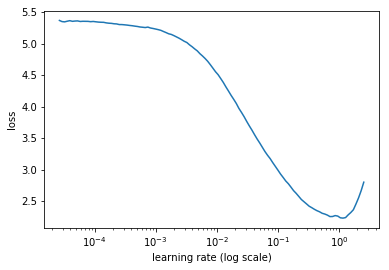

In [11]:
learn.sched.plot()

In [12]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.71276  0.3538   0.90421]                        
[ 1.       0.42086  0.31608  0.90948]                        



In [13]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.33835  0.30853  0.90996]                        
[ 1.       0.29211  0.29982  0.90853]                        
[ 2.       0.26722  0.30297  0.91188]                        



## Augment

In [11]:
from sklearn import metrics

In [10]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [17]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.85806  0.34839  0.90948]                        
[ 1.       0.47677  0.31811  0.91044]                        



In [13]:
learn.precompute=False
learn.bn_freeze=True

In [19]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.45997  0.29207  0.92337]                        
[ 1.       0.43489  0.28753  0.91954]                        
[ 2.       0.41633  0.28352  0.9205 ]                        
[ 3.       0.41345  0.28166  0.91954]                        
[ 4.       0.40497  0.28061  0.92337]                        



In [20]:
learn.save('224_i4_cr_pre')

In [21]:
learn.load('224_i4_cr_pre')

## Increase size

In [22]:
learn.set_data(get_data(350, bs))
learn.freeze()

In [23]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.2908   0.19481  0.94109]                        
[ 1.       0.26006  0.18597  0.94492]                        
[ 2.       0.27523  0.18715  0.94349]                        



In [24]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.24557  0.18852  0.94253]                        
[ 1.       0.26768  0.19465  0.94013]                        
[ 2.       0.23943  0.18922  0.94301]                        
[ 3.       0.24431  0.19084  0.9387 ]                        
[ 4.       0.23599  0.18772  0.94253]                        
[ 5.       0.21537  0.18727  0.94301]                        
[ 6.       0.20646  0.18788  0.94301]                        



In [25]:
learn.save('350_i4_cr_pre')

In [14]:
learn.load('350_i4_cr_pre')

In [15]:
learn.set_data(get_data(400, bs))
learn.freeze()

In [16]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.24342  0.17948  0.9478 ]                        
[ 1.       0.23019  0.17883  0.94732]                        
[ 2.       0.22358  0.18039  0.94349]                        



In [17]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.2106   0.18078  0.94492]                        
[ 1.       0.20209  0.18063  0.94444]                        
[ 2.       0.19232  0.18102  0.94636]                        
[ 3.       0.22369  0.18157  0.94492]                        
[ 4.       0.20311  0.18405  0.9454 ]                        
[ 5.       0.19209  0.18006  0.94684]                        
[ 6.       0.18459  0.18027  0.94732]                        



In [18]:
learn.save('400_i4_cr_pre')

In [19]:
learn.load('400_i4_cr_pre')

In [20]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

(0.94716242661448136, 0.17946231361904313)

In [21]:
learn.save('400_i4_cr_pre')

In [22]:
log_preds, y = learn.TTA(is_test=True)
probs_i4_400 = np.exp(log_preds)
#accuracy(log_preds, y), metrics.log_loss(y, probs)

In [23]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()

In [24]:
save_array('probs_i4_400.bc', probs_i4_400)

In [31]:
learn.fit(1e-2, 1, cycle_len=2)

A Jupyter Widget

[ 0.       0.23825  0.19766  0.94224]                        
[ 1.       0.21457  0.19238  0.94329]                        



In [32]:
learn.save('350_i4_pre')

In [33]:
log_preds, y = learn.TTA(is_test=True)
probs_i4_new = np.exp(log_preds)

In [34]:
save_array('probs_i4_new.bc', probs_i4_new)

## Use whole dataset now

In [31]:
learn.load('299_pre')

In [32]:
def get_data_whole(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=[0], suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [33]:
def load_array(fname): return bcolz.open(fname)[:]

In [34]:
data = get_data_whole(sz, bs)

A Jupyter Widget

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.freeze()

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


In [36]:
learn.fit(1e-2, 5)

A Jupyter Widget

[ 0.       0.75786  0.01884  1.     ]                         
[ 1.       0.38308  0.00202  1.     ]                         
[ 2.       0.27529  0.00073  1.     ]                         
[ 3.       0.22052  0.00052  1.     ]                         
[ 4.       0.19112  0.00022  1.     ]                         



In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [38]:
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       0.94042  0.00524  1.     ]                         
[ 1.       0.48962  0.00265  1.     ]                         



In [39]:
learn.precompute = False
learn.bn_freeze = True

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.44712  0.00127  1.     ]                        
[ 1.       0.39743  0.00121  1.     ]                        
[ 2.       0.34848  0.00075  1.     ]                        
[ 3.       0.35622  0.00137  1.     ]                        
[ 4.       0.31755  0.00057  1.     ]                        
[ 5.       0.28701  0.00074  1.     ]                        
 76%|███████▌  | 134/177 [03:41<01:10,  1.65s/it, loss=0.29] 

In [ ]:
learn.set_data(get_data_whole(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA(is_test=True)
probs_resnx101_64_full = np.exp(log_preds)
#accuracy(log_preds, y), metrics.log_loss(y, probs)

In [ ]:
save_array('probs_resnx101_64_full.bc', probs_resnx101_64_full)

In [ ]:
learn.save('299_full')

## Try ensembling
### Use another arch first

## Save to file for submission

In [25]:
df = pd.DataFrame(probs_i4_400)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [26]:
SUBM = f'{PATH}results_2/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission100.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]

In [ ]:
fn

In [ ]:
Image.open(PATH+fn).resize((150, 150))

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

In [ ]:
im = trn_tfms(Image.open(PATH+fn))
preds = to_np(learn.model(V(T(im[None]).cude())))
np.argmax(preds)

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
im = trn_tfms(Image.open(PATH+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)

## Confusion matrix

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)